## Bayesian Gaussian Process Latent Variable Model

We'll do dimensional reduction on single cell dataset to show to usefulness of informative prior and show that GPLVM can capture branching too.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

pyro.enable_validation()
pyro.set_rng_seed(0)

In [2]:
df = pd.read_excel("mmc4.xls", index_col=0)
df.head()

,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
Cell,,,,,,,,,,,,,,,,,,,,,
1C 1,14.01,19.28,23.89,28.0,28.0,21.28,20.84,28.00,23.08,17.17,...,18.24,13.94,23.84,16.33,22.54,22.82,16.26,28.0,28.0,18.53
1C 2,13.68,18.56,28.00,28.0,28.0,23.43,20.93,28.00,23.05,17.20,...,17.77,13.54,25.00,16.13,20.66,26.33,16.14,28.0,28.0,18.29
1C 3,13.42,18.19,26.18,28.0,28.0,22.87,19.61,28.00,21.73,17.05,...,17.51,13.50,28.00,15.90,20.32,22.93,15.47,28.0,28.0,18.92
1C 4,13.69,18.59,28.00,28.0,28.0,23.28,20.72,28.00,22.92,17.19,...,16.52,13.22,28.00,16.16,28.00,28.00,15.85,28.0,28.0,19.25
1C 5,13.47,18.60,24.20,28.0,28.0,24.19,21.75,23.69,22.41,17.23,...,17.82,13.41,24.26,16.15,20.15,24.32,16.05,28.0,28.0,18.77


In [3]:
N, C = df.shape

In [4]:
data = torch.tensor(df.values, dtype=torch.float)

In [5]:
y = ((data - data.mean(0)) / data.std(0, unbiased=False)).t()

In [6]:
pseudotime = torch.tensor([int(cell_name.split("C")[0]) for cell_name in df.index.values])

In [7]:
X_init = torch.zeros(N, 2)
X_init[:, 0] = (pseudotime.float() - 1) / 63

In [8]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))
likelihood = gp.likelihoods.Gaussian(variance=torch.tensor(0.01))
Xu = stats.resample(X_init, 40).clone()
gpmodel = gp.models.VariationalSparseGP(X_init.clone(), y, kernel, Xu, likelihood,
                                        whiten=True)
gplvm = gp.models.GPLVM(gpmodel)
gplvm.set_prior("X", dist.Normal(X_init.clone(), 0.1).to_event(2))
gplvm.autoguide("X", dist.Normal)
losses = gp.util.train(gplvm, num_steps=1400)

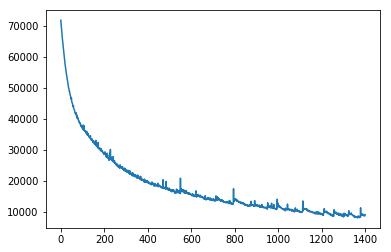

In [9]:
plt.plot(losses)

In [10]:
gplvm.mode = "guide"
X = gplvm.X

In [13]:
X = gplvm.X_loc

In [18]:
df.index

Index(['1C 1', '1C 2', '1C 3', '1C 4', '1C 5', '1C 6', '1C 7', '1C 8', '1C 9',
       '2C 1.1',
       ...
       '64C 7.5', '64C 7.6', '64C 7.7', '64C 7.8', '64C 7.9', '64C 7.10',
       '64C 7.11', '64C 7.12', '64C 7.13', '64C 7.14'],
      dtype='object', name='Cell', length=442)

Text(0.5,1,'GPLVM of single-cell dataset')

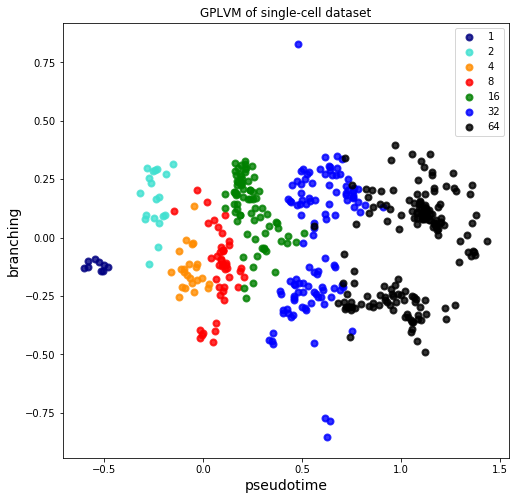

In [16]:
plt.figure(figsize=(8, 8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'blue', 'black']
lw = 2

for color, i in zip(colors, [1, 2, 4, 8, 16, 32, 64]):
    plt.scatter(X[pseudotime == i, 0].tolist(), X[pseudotime == i, 1].tolist(),
                color=color, alpha=.8, lw=lw, label=i)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title('GPLVM of single-cell dataset')

### References

+ `GrandPrix: Scaling up the Bayesian GPLVM for single-cell data`, by Sumon Ahmed, Magnus Rattray, Alexis Boukouvalas
+ `Resolution of Cell Fate Decisions Revealed by Single-Cell Gene Expression Analysis from Zygote to Blastocyst`, by Guoji Guo, Mikael Huss, Guo Qing Tong, Chaoyang Wang, Li Li Sun, Neil D. Clarke, Paul Robson
+ `Bayesian Gaussian Process Latent Variable Model`, by Michalis K. Titsias,
Neil D. Lawrence